# Training and testing models

## Imports

In [29]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configure matplotlib to show figures embedded in the notebook
%matplotlib inline

## Utilities

In [189]:
# Constants
NUM_SENSORS = 5

sensr_dir = 'raw_sensor_data/'
proc_sensr_dir = 'proc_sensor_data/'

hdpron_dir = 'hdpron/'
hdsup_dir = 'hdsup/'
heeldom_dir = 'heeldom/'
normal_dir = 'normal/'
heellift_dir = 'heellift/'
hlpron_dir = 'hlpron/'
hlsup_dir = 'hlsup/'
pron_dir = 'pron/'
sup_dir = 'sup/'
testing = 'testing/'

classes = {'hlpron': 0, 
           'hlsup': 1, 
           'sup': 2,
           'heellift': 3,
           'pron': 4, 
           'heeldom': 5,
           'hdpron': 6,
           'hdsup': 7,
           'normal': 8}

classes_inv = {0:'hlpron', 
               1:'hlsup', 
               2:'sup',
               3:'heellift',
               4:'pron',
               5: 'heeldom',
               6: 'hdpron',
               7: 'hdsup',
               8: 'normal'}

labels = {'hlpron': [classes['heellift'], classes['pron']], 
          'hlsup': [classes['heellift'], classes['sup']], 
          'sup': [classes['sup']],
          'heellift': [classes['heellift']],
          'pron': [classes['pron']], 
          'heeldom': [classes['heeldom']],
          'hdpron': [classes['heeldom'], classes['pron']],
          'hdsup': [classes['heeldom'], classes['sup']],
          'normal': []}

# data: an N by num_sensors matrix, where N number of readings
# returns a list of length num_sensors, each is an array of shape (N,)
# h: smoothing filter
def preprocess_sensor_data(data, num_sensors, h):
    return np.apply_along_axis(lambda row: np.convolve(row, h, mode='valid'), axis=0, arr=data)

# expects array-like data
def create_feature_vectors(data, offset=5):
    N, M = data.shape
    idx = 0
    X_t = []
    while idx + offset <= N:
        X_t.append(data[idx:idx+offset].flatten(order='F'))
        idx += offset
    return np.array(X_t)

def chained(sequences):
    for seq in sequences:
        yield from seq

def concatenate(sequences):
    sequences = iter(sequences)
    first = next(sequences)
    if hasattr(first, 'join'):
        return first + ''.join(sequences)
    return first + type(first)(chained(sequences))

## Convert Data to Feature Vectors + Labels

In [190]:
from os import listdir

X_train, Y_train, L_train = [], [], []
for cat in classes.keys():
    Xs, Ys, Ls = [], [], []
    for file in listdir(proc_sensr_dir + cat + '/'):
        data = np.load(proc_sensr_dir + cat + '/' + file)
        X_t = create_feature_vectors(data)
        N_t, M_t = X_t.shape
        Xs.append(X_t)
        Ys.append([classes[cat]] * N_t)
        Ls.append([labels[cat]] * N_t)
    X_train.append(np.vstack(Xs))
    Y_train.append(np.hstack(Ys))
    L_train.append(concatenate(Ls))

print(len(X_train))
print(len(Y_train))
print(len(L_train))

9
9
9


In [191]:
X = np.vstack(X_train)
Y = np.hstack(Y_train)
L = concatenate(L_train)

print(X.shape)
print(Y.shape)
print(len(L))

(3160, 25)
(3160,)
3160


## Prepare testing data

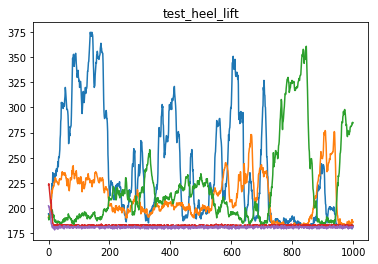

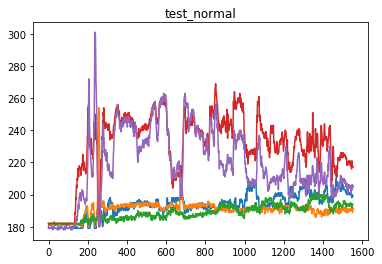

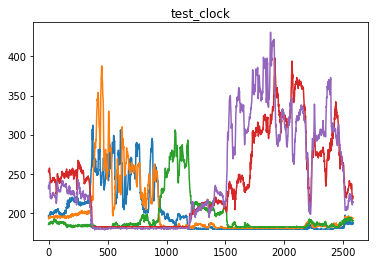

In [192]:
'''
test_hl is a dataset in which a squat is performed with heel-lift throughout.
'''
test_heel_lift = np.genfromtxt('input_heel_lift.csv', delimiter=',')
test_heel_lift = test_heel_lift[200:1200]

plt.figure()
plt.title('test_heel_lift')
plt.plot(test_heel_lift)
plt.show()

'''
test_normal is a dataset in which a squat is performed with normal footing.
'''
test_normal = np.genfromtxt(sensr_dir + testing + 'normal_squat.csv', delimiter=',')

plt.figure()
plt.title('test_normal')
plt.plot(test_normal)
plt.show()

'''
test_normal is a dataset in which a squat is peformed
with problematic footing, starting counterclockwise from pronation
'''
test_clock = np.genfromtxt(sensr_dir + testing + 'clock.csv', delimiter=',')

plt.figure()
plt.title('test_clock')
plt.plot(test_clock)
plt.show()

X_test_hl = create_feature_vectors(test_heel_lift)
X_test_normal = create_feature_vectors(test_normal)
X_test_clock = create_feature_vectors(test_clock)

## Train a multiclass Linear SVM

In [194]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

'''
train the model
'''
linear_svm_multicls = LinearSVC().fit(X, Y)

## Testing a multiclass Linear SVM

[2 8 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 3 1 1 0 0 0 0 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1]


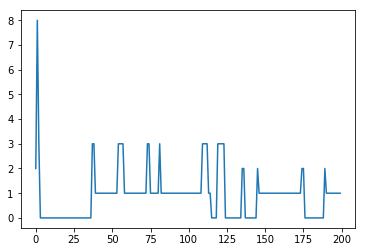

In [195]:
Z_hl = linear_svm_multicls.predict(X_test_hl)

print(Z_hl)

plt.figure()
plt.plot(Z_hl)
plt.show()

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 8
 8 8 8 2 0 5 2 2 8 0 1 0 0 0 0 0 2 5 0 0 8 8 8 8 8 8 8 8 8 5 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 8 8 5 8 5 0 0 5 0 0 5 0 0 0 0 0 0 0 0 5
 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 3 5 0 5 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 5 0 0 0 5 5 0 0 5 5 8 5 5 5 5 2 8 8 8 2 2 8 2 8 2 8 2
 2 2 2 2 2 8 8 8 8 8 8 8 8 8 5 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5 2 8 2 2 2 2
 2 2 2 2 2 2 2 2 8 8 8 8 2 8 8 8 8 8 8 5 5 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 2 8 8 2 2 2 2 2 2 2 2 2 2 8 8 8 2 5 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


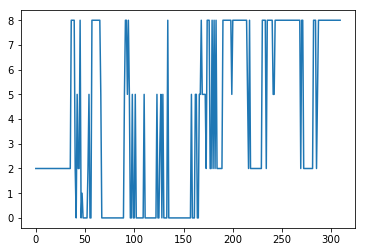

In [196]:
Z_normal = linear_svm_multicls.predict(X_test_normal)

print(Z_normal)

plt.figure()
plt.plot(Z_normal)
plt.show()

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 5 8 5 5 5 0 0 8 0 0 5 0 0 0 8 8 8 0 0 8
 8 8 8 4 0 0 8 4 4 4 8 0 0 0 8 8 4 4 8 4 8 8 8 0 0 0 0 0 0 8 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2
 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 0 0 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 2 8 2 2
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 6 6 6 6 6 6 6 6 0 

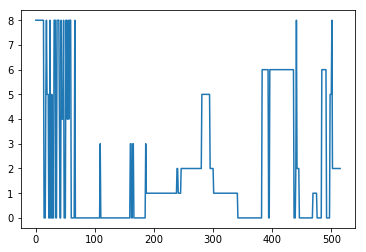

In [197]:
Z_clock = linear_svm_multicls.predict(X_test_clock)

print(Z_clock)

plt.figure()
plt.plot(Z_clock)
plt.show()

## Multilabel linear SVM Training

In [199]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

le = MultiLabelBinarizer()

Y_label = le.fit_transform(L)

print(Y_label)

clf = OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())).fit(X, Y_label)

[[0 1 1 0]
 [0 1 1 0]
 [0 1 1 0]
 ..., 
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


## Testing the multilabel linear svm

In [200]:
Z_hl = clf.predict(X_test_hl)

Z_hl = le.inverse_transform(Z_hl)
print(Z_hl)

[(), (), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3,), (3,), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (3, 4), (3,), (3,), (3,), (3,), (3,), (3,), (3, 4), (3, 4), (3,), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3,), (3, 4), (3, 4),

In [201]:
Z_normal = clf.predict(X_test_normal)

Z_normal = le.inverse_transform(Z_normal)

print(Z_normal)

[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (5,), (5,), (), (), (), (), (5,), (5,), (5,), (), (4,), (3, 4), (3,), (), (), (), (4,), (), (), (), (4,), (4,), (4,), (4,), (4,), (4,), (), (), (5,), (5,), (5,), (5,), (), (), (), (), (), (5,), (5,), (), (5,), (), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (5,), (5,), (5,), (), (), (), (), (5,), (5,), (5,), (5,), (5,), (5,), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (), (), (5,), (5,), (5,), (5,), (), (), (), (), (5,), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (5,), (), (), (5,), (5,), (5,), (5,), (), (), (), (), (), (), (4,), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (5,), (4, 5), (4, 5), (4,), (), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (), (), (), (), (), (

In [202]:
Z_clock = clf.predict(X_test_clock)

Z_clock = le.inverse_transform(Z_clock)

print(Z_clock)
print (len(Z_clock))

[(4,), (4,), (4,), (), (4,), (), (4,), (4,), (4,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4),

In [203]:
from sklearn.externals import joblib

##joblib.dump(clf, 'clf_multilabel_calibrated_v1.pkl') 

In [204]:
Z_scores = clf.predict_proba(X_test_clock)
Z_bin = clf.predict(X_test_clock)

In [205]:
mult_scores = np.multiply(Z_scores, Z_bin)

events = []

for a in mult_scores:
    event = {}
    idx = 0
    for score in a:
        if (score > 0):
            event[classes_inv[idx+2]] = score
        idx += 1
    events.append(event)

for e in events:
    print(e)
    
print (len(events))

{'pron': 0.53556069129206341}
{'pron': 0.51375486684139271}
{'pron': 0.51482808237390998}
{}
{'pron': 0.50608190697069166}
{}
{'pron': 0.50818655585238048}
{'pron': 0.51191426107914506}
{'pron': 0.50112801344939117}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'pron': 0.50248874723668013}
{'pron': 0.53053762410233574}
{'pron': 0.54698628916466674}
{'pron': 0.58301443900504246}
{'pron': 0.57960664275570672}
{'pron': 0.58114057189154933}
{'pron': 0.56446622690667125}
{'pron': 0.57871649915289802}
{'pron': 0.60069679179394997}
{'pron': 0.60423493938327277}
{'pron': 0.60318324912243348}
{'pron': 0.62253470634022301}
{'pron': 0.65060508264561978}
{'pron': 0.61835981580332322}
{'pron': 0.59432441273497971}
{'pron': 0.60757134402582424}
{'pron': 0.64346674118145042}
{'pron': 0.66345653794332626}
{'pron': 0.66100575823127394}
{'pron': 0.64576993931456184}
{'pron': 0.57897208639726705}
{'pron': 0.60128936142391043}
{'pron': 0.62619422574683059}
{'pron': 0.6243456305190288}
{'pron':

## Testing single value for online system

In [206]:
clf = joblib.load(clf_pkl)

a = [[0]*5]*5
A = np.array(a).reshape(1, 25)

print(A)

print (X_test_clock[0:1].reshape(25,).reshape(1, -1))
sing_Z_scores = clf.predict_proba(X_test_clock[0:1].reshape(25,).reshape(1, -1))
sing_Z_bin = clf.predict(X_test_clock[0:1].reshape(25,).reshape(1, -1))

sing_mult_scores = np.multiply(sing_Z_scores, sing_Z_bin)
print(sing_mult_scores.reshape(sing_mult_scores.shape[1],))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[ 196.  194.  195.  196.  196.  194.  194.  192.  193.  193.  185.  185.
   185.  185.  186.  253.  252.  252.  253.  253.  231.  235.  231.  232.
   234.]]
[ 0.          0.          0.53424212  0.        ]


## Logistic Regression

In [110]:
from sklearn.linear_model import LogisticRegression

log_clf = OneVsRestClassifier(LogisticRegression()).fit(X, Y_label)

In [111]:
Z_hl = log_clf.predict(X_test_hl)

Z_hl = le.inverse_transform(Z_hl)
print(Z_hl)

[(), (), (3,), (3,), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3,), (3,), (3,), (3,), (2, 3), (2, 3), (3,), (2, 3), (3,), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (2, 3), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3, 4), (3, 4), (3,), (3, 4), (3,), (3,), (3, 4), (3, 4), (3, 4), (3,), (3,), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (

In [112]:
Z_normal = log_clf.predict(X_test_normal)

Z_normal = le.inverse_transform(Z_normal)

print(Z_normal)

[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (5,), (5,), (), (), (), (5,), (2, 5), (5,), (), (4,), (4,), (), (), (), (5,), (4,), (), (), (), (4,), (4,), (), (), (), (), (), (5,), (5,), (5,), (5,), (5,), (5,), (5,), (), (5,), (5,), (5,), (5,), (5,), (5,), (5,), (5,), (), (5,), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (5,), (5,), (5,), (5,), (), (), (), (5,), (5,), (5,), (5,), (5,), (5,), (5,), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (5,), (5,), (5,), (), (5,), (5,), (5,), (5,), (5,), (5,), (), (), (5,), (), (), (), (5,), (), (), (), (), (), (), (), (), (), (5,), (5,), (), (), (5,), (5,), (5,), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (4,), (5,), (4,), (), (5,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (5,), (

In [113]:
Z_clock = log_clf.predict(X_test_clock)

Z_clock = le.inverse_transform(Z_clock)

print(Z_clock)

[(4,), (4,), (4,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,), (3,), (3,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4

In [101]:
print(log_clf.predict_proba(X_test_clock))

[[  5.71676922e-04   5.91184611e-34   7.51201628e-01   2.26007241e-01]
 [  5.03620723e-04   7.94206475e-35   5.05170331e-01   2.46338692e-01]
 [  4.43175310e-04   3.50915317e-31   6.21345617e-01   6.25323052e-02]
 ..., 
 [  4.76806661e-03   2.19763385e-27   9.30374866e-02   6.98024299e-02]
 [  5.44257010e-03   3.68924758e-22   3.06298008e-02   3.69542102e-02]
 [  8.34519784e-03   5.93796133e-18   2.73389339e-02   1.46125181e-02]]


## PCA

In [175]:
from sklearn.decomposition import PCA

N_COMPONENTS = 10

pca = PCA(n_components=N_COMPONENTS).fit(X)

X_pca = pca.transform(X)
X_test_clock_pca = pca.transform(X_test_clock)

le_pca = MultiLabelBinarizer()

Y_label_pca = le_pca.fit_transform(L)

In [178]:
clf = OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())).fit(X_pca, Y_label_pca)

In [179]:
Z_clock = clf.predict(X_test_clock_pca)

Z_clock = le.inverse_transform(Z_clock)

print(Z_clock)
print (len(Z_clock))

[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3,

In [180]:
joblib.dump(clf, 'clf_multilabel_calibrated_pca.pkl') 

['clf_multilabel_calibrated_pca.pkl']

In [181]:
Z_scores = clf.predict_proba(X_test_clock_pca)
Z_bin = clf.predict(X_test_clock_pca)

mult_scores = np.multiply(Z_scores, Z_bin)

events = []

for a in mult_scores:
    event = {}
    idx = 0
    for score in a:
        if (score > 0):
            event[classes_inv[idx+2]] = score
        idx += 1
    events.append(event)

for e in events:
    print(e)
    
print (len(events))

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'pron': 0.52538935162038036}
{'pron': 0.52229625739136532}
{'pron': 0.51528087021687685}
{'pron': 0.50367094813088731}
{'pron': 0.51016486859562982}
{'pron': 0.53542630577968364}
{'pron': 0.53824023938579091}
{'pron': 0.54007421816785606}
{'pron': 0.54617021078845596}
{'pron': 0.57482777263377882}
{'pron': 0.54814740894722458}
{'pron': 0.52683967469917392}
{'pron': 0.548013261201311}
{'pron': 0.57582188472416818}
{'pron': 0.58324417652411942}
{'pron': 0.58749488320416587}
{'pron': 0.57933303933803837}
{'pron': 0.5374935573295373}
{'pron': 0.5146299762091896}
{'pron': 0.5216411495463863}
{'pron': 0.52018443155832728}
{'pron': 0.52521081196492692}
{'pron': 0.56254293144062018}
{'pron': 0.57523514268601972}
{'pron': 0.57245878575340303}
{'pron': 0.57958906427621948}
{'pron': 0.56646037790936143}
{'pron': 0.55050996205768332}
{'pron': 0.55533803708904228}
{'pron': 0.54109582077320406}
{'pron': 0.5